#Load required libraries

In [1]:
# import all necessary libraries

import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.signal import argrelextrema
from scipy.stats import linregress
from scipy.optimize import curve_fit
import json
import requests
import datetime as dt
import time
import yfinance as yf
import seaborn as sns

#Pull Price Data

In [2]:
# import OHLC data from glassnode going back to 2013

# API key here
API_KEY = ["insert your key here :)"]

# report end dates

#yesterday = dt.date.today() - dt.timedelta(days=1)
#unixtimeyesterday = round(time.mktime(yesterday.timetuple()))

today = dt.date.today()
unixtimetoday = round(time.mktime(today.timetuple()))


# make API request
res = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_ohlc',
        params={'a': 'BTC', 'api_key': API_KEY, 's': '1278716400', 'u': unixtimetoday,
            'i': '24h','f':'JSON', 'timestamp_format':'unix'})

# convert to pandas dataframe
df = pd.read_json(res.text)

In [3]:
# rework df to explode price dictionary into multiple columns and rename them

# split OHLC dictionary into multiple columns

df_glasnode_ohlc = pd.json_normalize(df['o'])

# append exploded ohlc values into the original df

df = pd.concat([df.drop(['o'], axis=1), df_glasnode_ohlc], axis=1)

# rename the columns

df = df.rename(columns={'t':'date','c':'close','h':'high', 'l':'low', 'o':'open'})

In [4]:
# transform unix to UTC

df['date'] = pd.to_datetime(df['date'],unit='s')

In [5]:
# reorder columns

df = df[['date','open', 'high', 'low', 'close']]

In [6]:
# check if we're ready to start working with bitcoin daily price data since 2013...

df.tail()

,date,open,high,low,close
4654,2023-04-14,30407.447661,30974.457433,30118.216763,30476.951739
4655,2023-04-15,30497.831172,30598.170884,30255.475421,30311.345452
4656,2023-04-16,30318.801318,30555.537633,30157.832325,30307.756522
4657,2023-04-17,30312.049392,30316.498436,29318.172868,29459.379649
4658,2023-04-18,29445.044905,30456.638904,29242.327992,30374.505587


#Create df with monthly data

In [7]:
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')

df.head(2)

,date,open,high,low,close,month_year
0,2010-07-17,0.04951,0.04951,0.04951,0.04951,2010-07
1,2010-07-18,0.05941,0.08585,0.05941,0.08584,2010-07


In [8]:
#create new column with beginning of the month

from pandas.tseries.offsets import MonthBegin

df['month_begin'] = pd.to_datetime(df['date'], format="%Y%m%d") + MonthBegin(0)
                                                                             

df.tail(1)

,date,open,high,low,close,month_year,month_begin
4658,2023-04-18,29445.044905,30456.638904,29242.327992,30374.505587,2023-04,2023-05-01


In [9]:
#keep only rows with beginning of the month equals actual date to create a df with monthly data only

month_begin_flag = []

for i, j in zip(df['date'], df['month_begin']):
  if i == j:
    month_begin_flag.append(1)
  else:
    month_begin_flag.append(0)


In [10]:
df['month_begin_flag'] = month_begin_flag

df.tail(14)

,date,open,high,low,close,month_year,month_begin,month_begin_flag
4645,2023-04-05,28169.726953,28680.996600,27891.778627,28173.736292,2023-04,2023-05-01,0
4646,2023-04-06,28175.227077,28175.227077,27779.475500,28041.197531,2023-04,2023-05-01,0
4647,2023-04-07,28044.139755,28106.520499,27824.147664,27924.680589,2023-04,2023-05-01,0
4648,2023-04-08,27920.512779,28158.794267,27883.386553,27942.767666,2023-04,2023-05-01,0
4649,2023-04-09,27952.367616,28488.610678,27844.943250,28340.416854,2023-04,2023-05-01,0
4650,2023-04-10,28336.028237,29771.463929,28208.099480,29628.544376,2023-04,2023-05-01,0
4651,2023-04-11,29653.679647,30450.202561,29629.853020,30254.021967,2023-04,2023-05-01,0
4652,2023-04-12,30231.581623,30462.480941,29790.916246,29887.199959,2023-04,2023-05-01,0
4653,2023-04-13,29892.739460,30539.846481,29878.622163,30391.673896,2023-04,2023-05-01,0
4654,2023-04-14,30407.447661,30974.457433,30118.216763,30476.951739,2023-04,2023-05-01,0


In [11]:
df.shape

(4659, 8)

In [12]:
#drop all rows where month_begin_flag isn't 1

df = df[df.month_begin_flag != 0]

df.shape

(153, 8)

In [13]:
df.tail(3)

,date,open,high,low,close,month_year,month_begin,month_begin_flag
4582,2023-02-01,23139.363844,23764.034230,22968.082176,23711.527629,2023-02,2023-02-01,1
4610,2023-03-01,23150.929958,23871.920130,23095.041677,23652.749774,2023-03,2023-03-01,1
4641,2023-04-01,28478.484606,28778.746034,28311.398411,28473.568378,2023-04,2023-04-01,1


In [14]:
#clean up dataframe from unnecessary columns 

df = df.drop(columns=['month_begin', 'month_begin_flag'])

df = df.reset_index(drop=True)

df.tail(2)

,date,open,high,low,close,month_year
151,2023-03-01,23150.929958,23871.920130,23095.041677,23652.749774,2023-03
152,2023-04-01,28478.484606,28778.746034,28311.398411,28473.568378,2023-04


#Work on central bank data

In [15]:
# continue with the Fed total assests https://fred.stlouisfed.org/series/WALCL#0

df_fedassets = pd.read_csv("/content/WALCL_monthly.csv")

df_fedassets.head(3)

,DATE,WALCL
0,2003-01-01,724718.400000000000
1,2003-02-01,721326.000000000000
2,2003-03-01,723651.250000000000


In [16]:
#rename column 'DATE' to month

df_fedassets = df_fedassets.rename(columns={'DATE':'date', 'WALCL':'fed_assets_USDM'})

In [17]:
#convert date to datetime

df_fedassets['date'] = pd.to_datetime(df_fedassets['date'])

In [18]:
#join monthly fed assets with original df

df = pd.merge(df, 
              df_fedassets, 
              on ='date', 
              how ='left')

In [19]:
# fill empty values with the previous one

df['fed_assets_USDM'].fillna(method='ffill', inplace=True)

In [20]:
# continue with Bank of Japan assets https://fred.stlouisfed.org/series/JPNASSETS#0

df_jpn = pd.read_csv("/content/JPNASSETS.csv")

df_jpn.head(4)


,DATE,JPNASSETS
0,1998-04-01,800652.0
1,1998-05-01,771888.0
2,1998-06-01,753964.0
3,1998-07-01,724375.0


In [21]:
#rename column 'DATE' to month

df_jpn = df_jpn.rename(columns={'DATE':'date', 'JPNASSETS':'japan_assets'})

#convert date to datetime

df_jpn['date'] = pd.to_datetime(df_jpn['date'])

#join monthly fed assets with original df

df = pd.merge(df, 
              df_jpn, 
              on ='date', 
              how ='left')

In [22]:
# continue with European central bank assets https://fred.stlouisfed.org/series/ECBASSETSW

df_eur = pd.read_csv("/content/ECBASSETSW.csv")

df_eur.head(4)


,DATE,ECBASSETSW
0,1999-01-01,686308.000000000000
1,1999-02-01,685553.750000000000
2,1999-03-01,689701.500000000000
3,1999-04-01,709898.400000000000


In [23]:
#rename column 'DATE' to month

df_eur = df_eur.rename(columns={'DATE':'date', 'ECBASSETSW':'euro_assets'})

#convert date to datetime

df_eur['date'] = pd.to_datetime(df_eur['date'])

#join monthly fed assets with original df

df = pd.merge(df, 
              df_eur, 
              on ='date', 
              how ='left')

In [24]:
# continue with overnight repo https://fred.stlouisfed.org/series/RRPONTSYD#0

df_repo = pd.read_csv("/content/RRPONTSYD.csv")

df_repo.head(4)


,DATE,RRPONTSYD
0,2012-09-01,0.06000000000000000000
1,2012-10-01,.
2,2012-11-01,1.18000000000000000000
3,2012-12-01,.


In [25]:
#rename column 'DATE' to month

df_repo = df_repo.rename(columns={'DATE':'date', 'RRPONTSYD':'repo_value'})

#convert date to datetime

df_repo['date'] = pd.to_datetime(df_repo['date'])

#join monthly fed assets with original df

df = pd.merge(df, 
              df_repo, 
              on ='date', 
              how ='left')

# fill empty values with the previous one 
df['repo_value'].fillna(method='ffill', inplace=True)

In [26]:
# continue with liabilities and capital https://fred.stlouisfed.org/series/WTREGEN#0

df_wtregen = pd.read_csv("/content/WTREGEN.csv")

df_wtregen.head(4)

,DATE,WTREGEN
0,1986-01-01,10.1287500000000000
1,1986-02-01,8.1045000000000000
2,1986-03-01,3.6567500000000000
3,1986-04-01,3.7348000000000000


In [27]:
#rename column 'DATE' to month

df_wtregen = df_wtregen.rename(columns={'DATE':'date', 'WTREGEN':'fed_capital_liabilities'})

#convert date to datetime

df_wtregen['date'] = pd.to_datetime(df_wtregen['date'])

#join monthly fed assets with original df

df = pd.merge(df, 
              df_wtregen, 
              on ='date', 
              how ='left')

# fill empty values with the previous one 
df['fed_capital_liabilities'].fillna(method='ffill', inplace=True)

In [28]:
df.tail(3)

,date,open,high,low,close,month_year,fed_assets_USDM,japan_assets,euro_assets,repo_value,fed_capital_liabilities
150,2023-02-01,23139.363844,23764.034230,22968.082176,23711.527629,2023-02,8408984.000000000000,7395800.0,7865135.000000000000,2079.4516315789473684,505.2695000000000000
151,2023-03-01,23150.929958,23871.920130,23095.041677,23652.749774,2023-03,8552199.200000000000,7348498.0,7811511.200000000000,2185.6840000000000000,278.1250000000000000
152,2023-04-01,28478.484606,28778.746034,28311.398411,28473.568378,2023-04,.,NaN,.,.,.


# Transform Yens and Euros to USD

In [29]:
import yfinance as yf

# Define ticker symbol
tickerSymbol = 'JPYUSD=X'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

yesterday = dt.date.today()

last_14_years = dt.date.today() - dt.timedelta(days=5110)

# Get the historical prices for this ticker

jpy_usd = yf.download(tickerSymbol,last_14_years,yesterday)

jpy_usd = jpy_usd.reset_index()

jpy_usd = jpy_usd[['Date', 'Close']]

jpy_usd = jpy_usd.rename(columns={'Date':'date', 'Close':'jpy_usd'})

#convert date to datetime

jpy_usd['date'] = pd.to_datetime(jpy_usd['date'])

# Get the latest JPY/USD exchange rate
jpy_usd.tail(2)


[*********************100%***********************]  1 of 1 completed


,date,jpy_usd
3643,2023-04-17,0.007464
3644,2023-04-18,0.007439


In [30]:
#join monthly fed assets with original df

df = pd.merge(df, 
              jpy_usd, 
              on ='date', 
              how ='left')

# fill empty values with the previous one 
df['jpy_usd'].fillna(method='ffill', inplace=True)

In [31]:
df.tail(4)

,date,open,high,low,close,month_year,fed_assets_USDM,japan_assets,euro_assets,repo_value,fed_capital_liabilities,jpy_usd
149,2023-01-01,16547.854189,16630.439003,16522.473408,16620.819927,2023-01,8493903.000000000000,7337761.0,7948314.500000000000,2131.0838500000000000,406.7077500000000000,0.007280
150,2023-02-01,23139.363844,23764.034230,22968.082176,23711.527629,2023-02,8408984.000000000000,7395800.0,7865135.000000000000,2079.4516315789473684,505.2695000000000000,0.007686
151,2023-03-01,23150.929958,23871.920130,23095.041677,23652.749774,2023-03,8552199.200000000000,7348498.0,7811511.200000000000,2185.6840000000000000,278.1250000000000000,0.007334
152,2023-04-01,28478.484606,28778.746034,28311.398411,28473.568378,2023-04,.,NaN,.,.,.,0.007334


In [32]:
# Define ticker symbol
tickerSymbol = 'EURUSD=X'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

yesterday = dt.date.today()

last_14_years = dt.date.today() - dt.timedelta(days=5110)

# Get the historical prices for this ticker

eur_usd = yf.download(tickerSymbol,last_14_years,yesterday)

eur_usd = eur_usd.reset_index()

eur_usd = eur_usd[['Date', 'Close']]

eur_usd = eur_usd.rename(columns={'Date':'date', 'Close':'eur_usd'})

#convert date to datetime

eur_usd['date'] = pd.to_datetime(eur_usd['date'])

# Get the latest JPY/USD exchange rate
eur_usd.tail(2)


[*********************100%***********************]  1 of 1 completed


,date,eur_usd
3643,2023-04-17,1.098660
3644,2023-04-18,1.092538


In [33]:
#join monthly fed assets with original df

df = pd.merge(df, 
              eur_usd, 
              on ='date', 
              how ='left')

# fill empty values with the previous one 
df['eur_usd'].fillna(method='ffill', inplace=True)

In [34]:
df.tail(4)

,date,open,high,low,close,month_year,fed_assets_USDM,japan_assets,euro_assets,repo_value,fed_capital_liabilities,jpy_usd,eur_usd
149,2023-01-01,16547.854189,16630.439003,16522.473408,16620.819927,2023-01,8493903.000000000000,7337761.0,7948314.500000000000,2131.0838500000000000,406.7077500000000000,0.007280,1.042535
150,2023-02-01,23139.363844,23764.034230,22968.082176,23711.527629,2023-02,8408984.000000000000,7395800.0,7865135.000000000000,2079.4516315789473684,505.2695000000000000,0.007686,1.086095
151,2023-03-01,23150.929958,23871.920130,23095.041677,23652.749774,2023-03,8552199.200000000000,7348498.0,7811511.200000000000,2185.6840000000000000,278.1250000000000000,0.007334,1.057731
152,2023-04-01,28478.484606,28778.746034,28311.398411,28473.568378,2023-04,.,NaN,.,.,.,0.007334,1.057731


In [35]:
#fill remaining nulls with np.nan

# Fill nulls with NaN
df['fed_assets_USDM']= df['fed_assets_USDM'].fillna(np.nan)
df['euro_assets']= df['euro_assets'].fillna(np.nan)
df['repo_value'] = df['repo_value'].fillna(np.nan)
df['fed_capital_liabilities'] = df['fed_capital_liabilities'].fillna(np.nan)

# Replace '.' with NaN
df['fed_assets_USDM']= df['fed_assets_USDM'].replace({'.': np.nan})
df['euro_assets'] = df['euro_assets'].replace({'.': np.nan})
df['repo_value'] = df['repo_value'].replace({'.': np.nan})
df['fed_capital_liabilities'] = df['fed_capital_liabilities'].replace({'.': np.nan})

# Convert euro_assets column to float64
df['fed_assets_USDM'] = df['fed_assets_USDM'].astype('float64')
df['euro_assets'] = df['euro_assets'].astype('float64')
df['repo_value'] = df['repo_value'].astype('float64')
df['fed_capital_liabilities'] = df['fed_capital_liabilities'].astype('float64')



In [36]:
# create new fields for Bank of Japan and European Central bank in millions of USD

df['japan_assets_USDM'] = df['japan_assets']*100000000*df['jpy_usd']/1000000

df['euro_assets_USDM'] = df['euro_assets']*df['eur_usd']


In [37]:
# Set the display format for floats
pd.options.display.float_format = '{:.2f}'.format

df.tail(2)

,date,open,high,low,close,month_year,fed_assets_USDM,japan_assets,euro_assets,repo_value,fed_capital_liabilities,jpy_usd,eur_usd,japan_assets_USDM,euro_assets_USDM
151,2023-03-01,23150.93,23871.92,23095.04,23652.75,2023-03,8552199.20,7348498.00,7811511.20,2185.68,278.12,0.01,1.06,5389516.39,8262476.87
152,2023-04-01,28478.48,28778.75,28311.40,28473.57,2023-04,NaN,NaN,NaN,NaN,NaN,0.01,1.06,NaN,NaN


In [38]:
# transform repo_value and fed_capital_liabilities to millions of usd 

df['repo_value_USDM'] = df['repo_value']*1000

df['fed_capital_liabilities_USDM'] = df['fed_capital_liabilities']*1000


In [39]:
# create a new field with total central bank assets 

df['total_central_bank_assets_USDM'] = df['fed_assets_USDM']+df['japan_assets_USDM']+df['euro_assets_USDM']

df['total_market_liquidity'] = df['total_central_bank_assets_USDM'] - df['repo_value_USDM'] - df['fed_capital_liabilities_USDM']

In [40]:
df.tail(3)

,date,open,high,low,close,month_year,fed_assets_USDM,japan_assets,euro_assets,repo_value,fed_capital_liabilities,jpy_usd,eur_usd,japan_assets_USDM,euro_assets_USDM,repo_value_USDM,fed_capital_liabilities_USDM,total_central_bank_assets_USDM,total_market_liquidity
150,2023-02-01,23139.36,23764.03,22968.08,23711.53,2023-02,8408984.00,7395800.00,7865135.00,2079.45,505.27,0.01,1.09,5684267.12,8542281.73,2079451.63,505269.50,22635532.85,20050811.72
151,2023-03-01,23150.93,23871.92,23095.04,23652.75,2023-03,8552199.20,7348498.00,7811511.20,2185.68,278.12,0.01,1.06,5389516.39,8262476.87,2185684.00,278125.00,22204192.46,19740383.46
152,2023-04-01,28478.48,28778.75,28311.40,28473.57,2023-04,NaN,NaN,NaN,NaN,NaN,0.01,1.06,NaN,NaN,NaN,NaN,NaN,NaN


# Charts

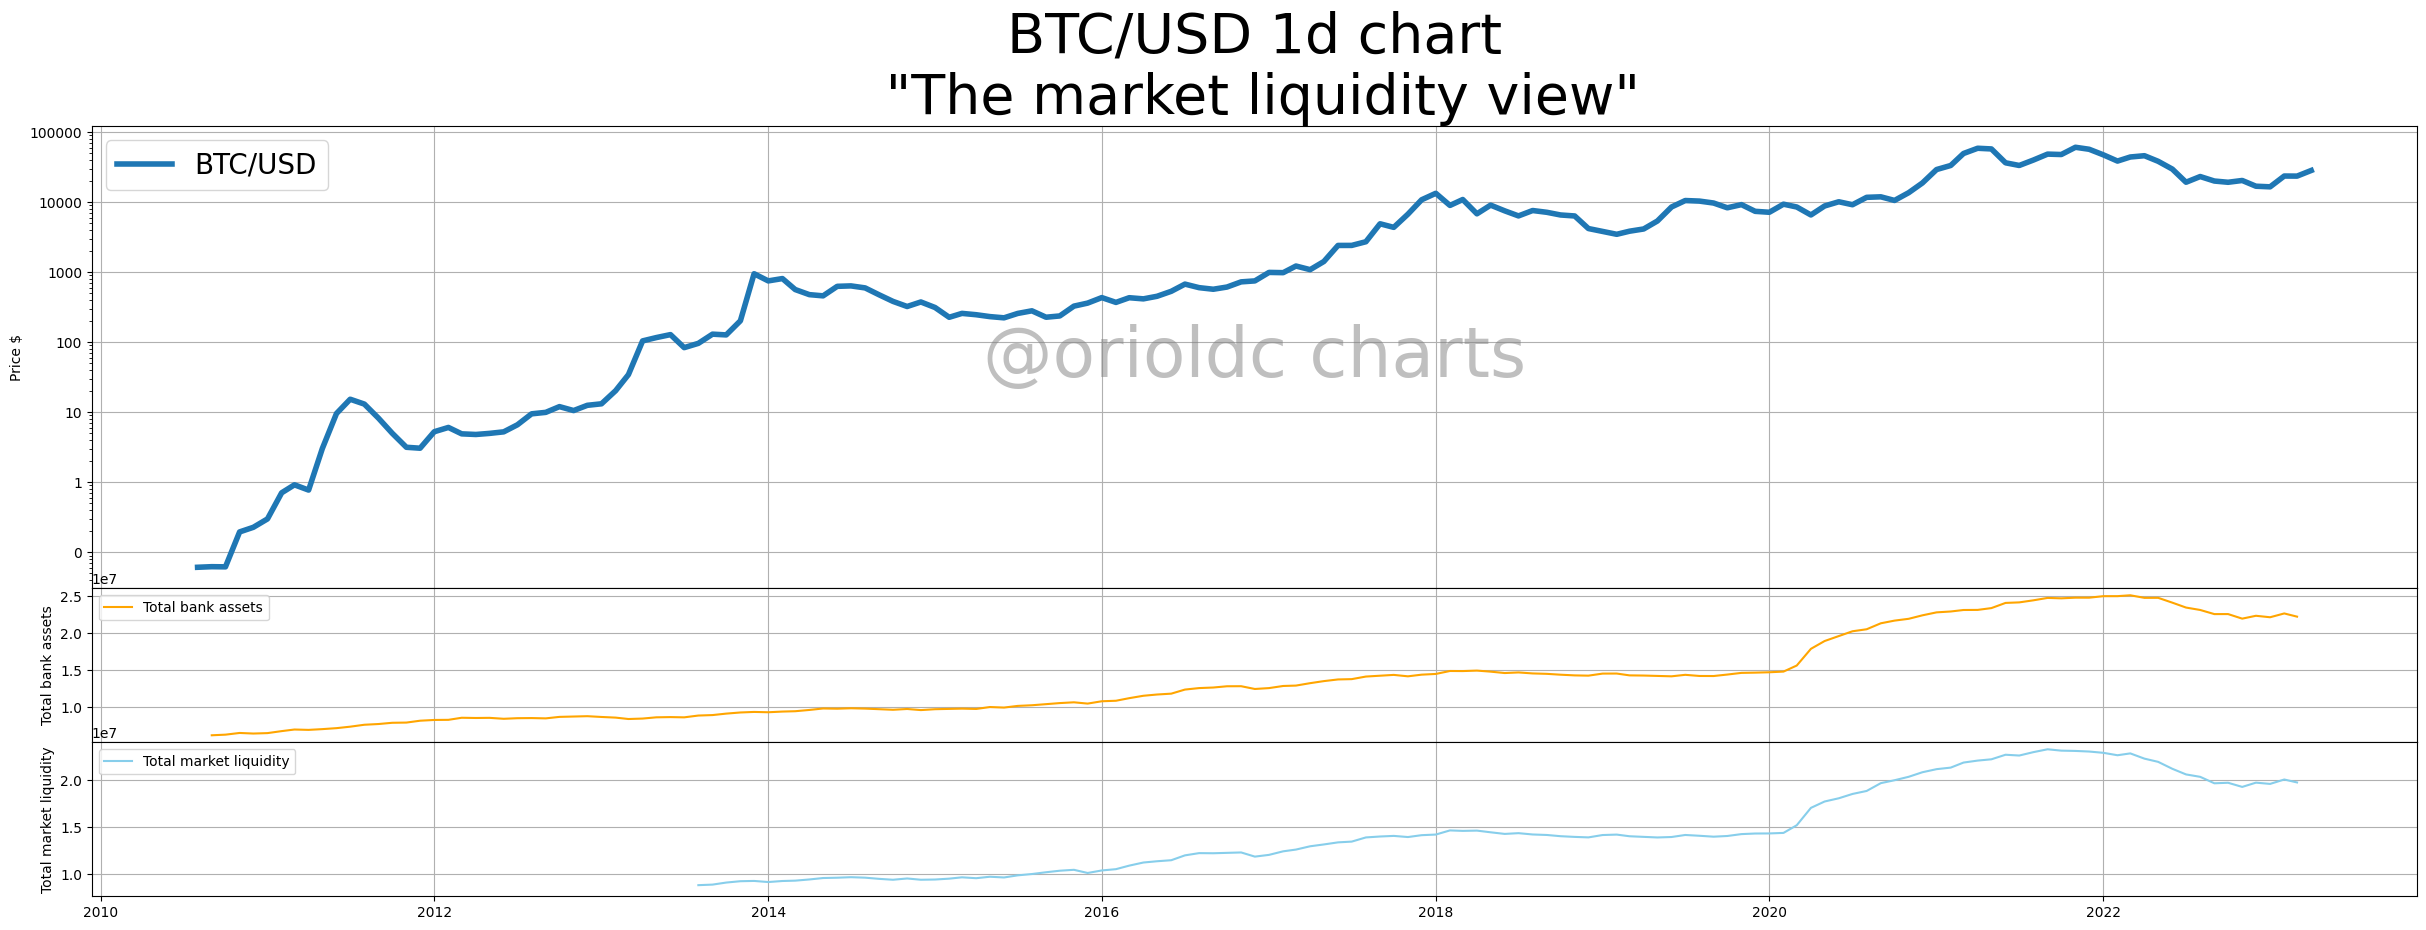

In [41]:
#plot btc price with fed data

fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw={'height_ratios': [3,1,1]}, figsize=(30,10))

x = df['date']
ticks = [0, 100, 300, 500, 1000, 3000, 5000, 10000, 20000, 40000, 50000, 70000]
labels = ['BTC/USD']
yesterday = dt.date.today() - dt.timedelta(days=1)
filename = 'BtcUsd_FedView_v1_{}.jpg'.format(yesterday)

#plot price

ax0.plot(x, df['close'], linewidth = 4)
ax0.set_yscale('log')
#ax0.set_yticks(ticks, minor=False)
ax0.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
ax0.set_ylabel('Price $')
ax0.set_title('BTC/USD 1d chart\n "The market liquidity view"', size=40)
ax0.legend(labels, loc='upper left', prop={'size': 20})
ax0.text(0.5, 0.5, '@orioldc charts', transform=ax0.transAxes,
        fontsize=50, color='gray', alpha=0.5,
        ha='center', va='center')
ax0.grid(True)

#plot fed funds rate

ax1.plot(x, df['total_central_bank_assets_USDM'], color='orange')
ax1.set_ylabel('Total bank assets')
ax1.legend(labels=['Total bank assets'], loc='upper left', prop={'size': 10})
ax1.grid(True)

#plot fed assets

ax2.plot(x, df['total_market_liquidity'], color='skyblue')
ax2.set_ylabel('Total market liquidity')
ax2.legend(labels=['Total market liquidity'], loc='upper left', prop={'size': 10})
ax2.grid(True)

# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)
#plt.savefig(filename, facecolor='white', dpi=96)
#files.download(filename)
plt.show()

In [42]:
# Replace null values in total_market_liquidity with values from total_central_bank_assets_USDM
df['total_market_liquidity'] = df['total_market_liquidity'].fillna(df['total_central_bank_assets_USDM'])

In [43]:
df.head(5)

,date,open,high,low,close,month_year,fed_assets_USDM,japan_assets,euro_assets,repo_value,fed_capital_liabilities,jpy_usd,eur_usd,japan_assets_USDM,euro_assets_USDM,repo_value_USDM,fed_capital_liabilities_USDM,total_central_bank_assets_USDM,total_market_liquidity
0,2010-08-01,0.06,0.07,0.06,0.06,2010-08,2317172.25,1230414.00,1957995.50,NaN,27.66,NaN,NaN,NaN,NaN,NaN,27664.00,NaN,NaN
1,2010-09-01,0.06,0.06,0.06,0.06,2010-09,2301947.80,1203317.00,1969579.00,NaN,40.69,0.01,1.27,1430136.70,2498863.11,NaN,40693.80,6230947.61,6230947.61
2,2010-10-01,0.06,0.06,0.06,0.06,2010-10,2304649.00,1214171.00,1876885.00,NaN,42.19,0.01,1.36,1452878.98,2556715.83,NaN,42189.50,6314243.81,6314243.81
3,2010-11-01,0.19,0.20,0.17,0.20,2010-11,2318469.75,1270457.00,1892420.25,NaN,26.76,0.01,1.40,1580052.57,2644670.23,NaN,26759.75,6543192.55,6543192.55
4,2010-12-01,0.21,0.23,0.21,0.23,2010-12,2392691.80,1287104.00,1950321.80,NaN,53.12,0.01,1.30,1538162.91,2533872.61,NaN,53121.20,6464727.32,6464727.32


#Stats

In [44]:
#correlation between bitcoin price and Fed Assets

df['fed_assets_USDM'] = pd.to_numeric(df['fed_assets_USDM'],errors = 'coerce')

btcprice = df['close']
fed_assets = df['fed_assets_USDM']

btcprice.corr(fed_assets, method='pearson')

0.8251545999981734

In [45]:
#correlation between bitcoin price and total central bank assets

#df['fed_assets_USDM'] = pd.to_numeric(df['fed_assets_USDM'],errors = 'coerce')

btcprice = df['close']
fed_assets = df['total_central_bank_assets_USDM']

btcprice.corr(fed_assets, method='pearson')

0.861046067129849

In [46]:
#correlation between bitcoin price and total liquidity

#df['fed_assets_USDM'] = pd.to_numeric(df['fed_assets_USDM'],errors = 'coerce')

btcprice = df['close']
fed_assets = df['total_market_liquidity']

btcprice.corr(fed_assets, method='pearson')

0.8659792535643986

#Regression analysis

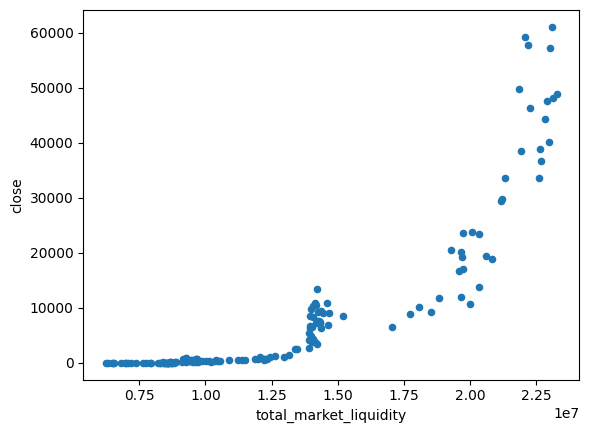

In [47]:
# Visualize the data in a scatter plot

df.plot(kind='scatter', x='total_market_liquidity', y='close')
plt.show()


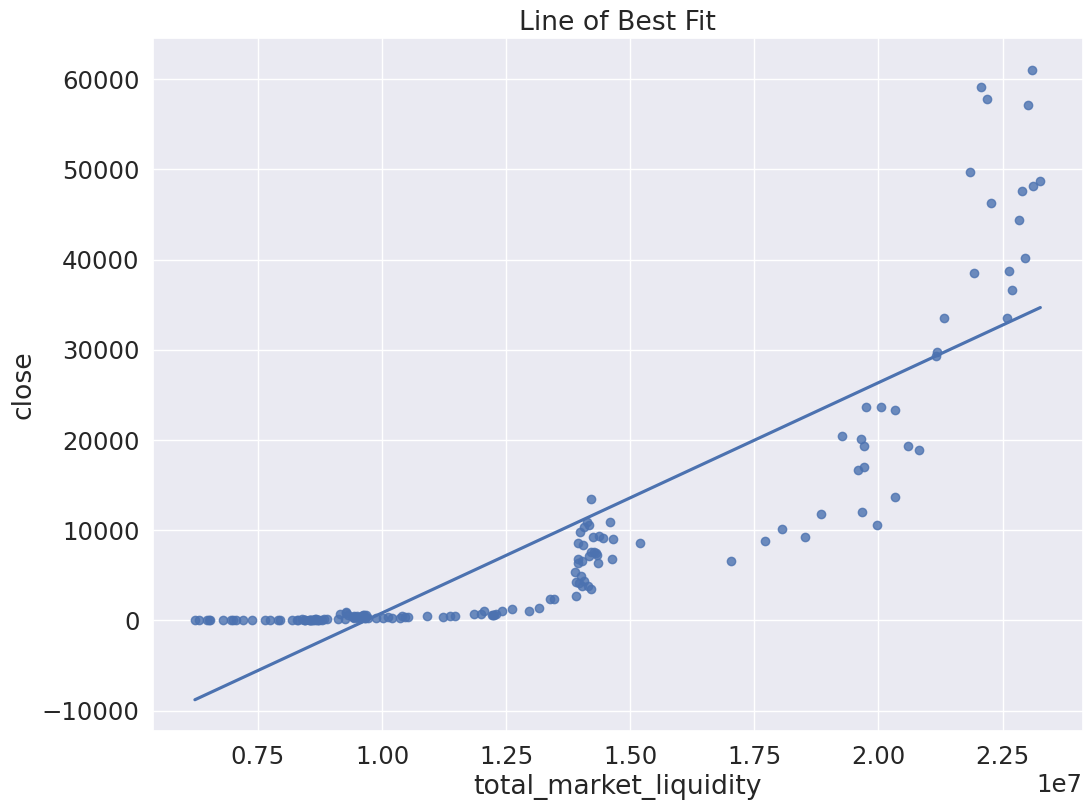

In [48]:
# plot a first line of best fit 

sns.set(font_scale=1.6)

fig, ax1 = plt.subplots(figsize=(12, 9))

ax1 = sns.regplot(x='total_market_liquidity', y='close', data=df, ci=None)
ax1.set_title("Line of Best Fit");

In [49]:
import sklearn.linear_model

#instantiate the linear model

model_lr = sklearn.linear_model.LinearRegression()

In [50]:
df.shape

(153, 19)

In [51]:
# Drop rows where total_central_bank_assets_USDM is null
df = df.dropna(subset=['total_central_bank_assets_USDM'])

In [52]:
df.shape

(151, 19)

In [53]:
#define variables and fit the model

X = np.c_[df['total_market_liquidity']]

y = np.c_[df['close']]

# Train the model
model_lr.fit(X, y)

LinearRegression()

In [54]:
# print coefficients for the simple linear regression

print("Slope Coefficient of Fed Assets: {}".format(model_lr.coef_, 2))
print("Intercept Coefficient of Fed Assets: {}".format(model_lr.intercept_))

Slope Coefficient of Fed Assets: [[0.00255381]]
Intercept Coefficient of Fed Assets: [-24715.10424521]


#Understand output of regression

In [55]:
def estimated_btc_price(bank_assets, coeff, inter):
    bank_assets = round(bank_assets, 2)
    est_y = (bank_assets * coeff) + inter
    prediction = est_y
    
    return prediction

In [56]:
# run forecast based on Fed Assets 

intercept = model_lr.intercept_
coefficient = model_lr.coef_
bank_assets = 17000000

estimated_btc_price(bank_assets, coefficient, intercept)



array([[18699.69564494]])

In [57]:
# Pass data and `formula` into ols(), use and `.fit()` the model to the data
from statsmodels.formula.api import ols

model_fit = ols(formula="close ~ fed_assets_USDM", data=df).fit()

In [58]:
# extract key model parameters

x1 = model_fit.params['fed_assets_USDM']

print( "uplift factor for fed_assets_USDM = {p}".format(p=x1) )
print( model_fit.summary() )

uplift factor for fed_assets_USDM = 0.006193579719252616
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     318.8
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           7.52e-39
Time:                        11:06:47   Log-Likelihood:                -1576.0
No. Observations:                 151   AIC:                             3156.
Df Residuals:                     149   BIC:                             3162.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [59]:
# check the quality of the model

y_pred = model_lr.predict(X)

In [60]:
#comparisson between predicted prices and actual prices

comparison = pd.DataFrame(np.append(y, y_pred, axis=1), columns=["Actuals", "Prediction"], index=df.index)
comparison.tail()

,Actuals,Prediction
147,20481.88,24484.36
148,16962.99,25639.78
149,16620.82,25300.13
150,23711.53,26490.89
151,23652.75,25698.12


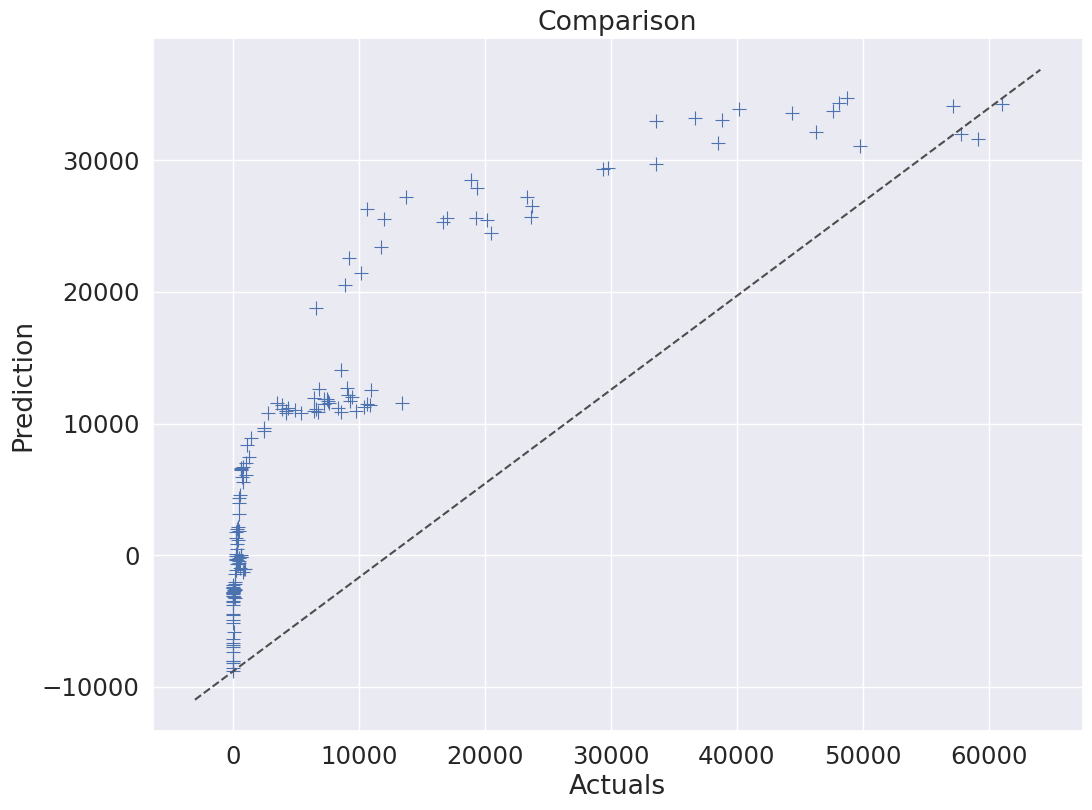

In [61]:
sns.set(font_scale=1.6)

fig, ax1 = plt.subplots(figsize=(12, 9))

ax1 = sns.scatterplot(x="Actuals", y="Prediction", data=comparison, ax=ax1, s=100, marker="+")
ax1.set_title("Comparison")
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")

In [62]:
# Score directly with the model, default: R2
r2 = model_lr.score(X, y)

print(r2)

0.7499200676039537


#Run regression analysis removing the first few years (before BTC became a financial asset)

In [63]:
#filter data

# Filter data between two dates
df_2016 = df.loc[(df['date'] >= '2016-01-01')]

df_2016 = df_2016.set_index('date')

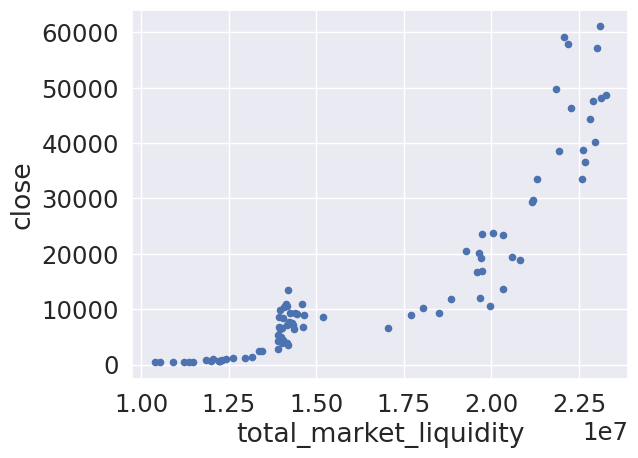

In [64]:
# Visualize the data

df_2016.plot(kind='scatter', x='total_market_liquidity', y='close')
plt.show()

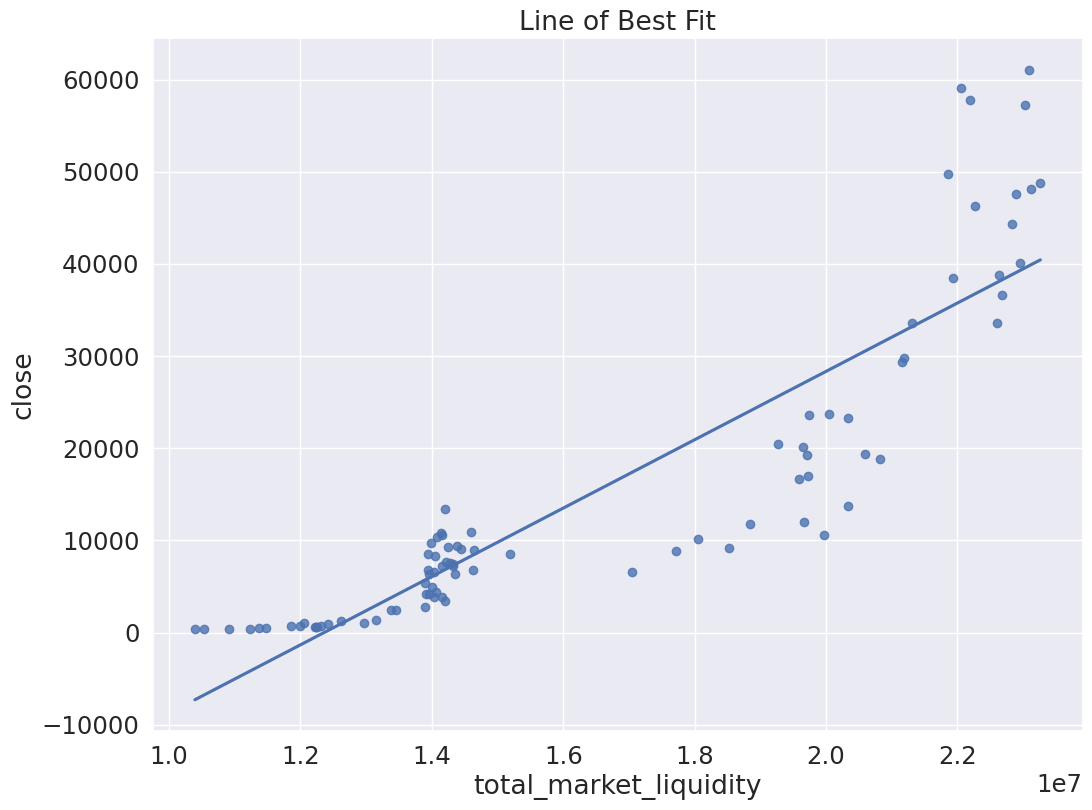

In [65]:
# display line of best fit

sns.set(font_scale=1.6)

fig, ax1 = plt.subplots(figsize=(12, 9))

ax1 = sns.regplot(x='total_market_liquidity', y='close', data=df_2016, ci=None)
ax1.set_title("Line of Best Fit");

In [66]:
#instantiate the model

model_lr_16 = sklearn.linear_model.LinearRegression()

In [67]:
#define variables and fit the model

X = np.c_[df_2016['total_market_liquidity']]

y = np.c_[df_2016['close']]

# Train the model
model_lr_16.fit(X, y)

LinearRegression()

In [68]:
# print coefficients

print("Slope Coefficient of Fed Assets: {}".format(model_lr_16.coef_, 2))
print("Intercept Coefficient of Fed Assets: {}".format(model_lr_16.intercept_))

Slope Coefficient of Fed Assets: [[0.00370772]]
Intercept Coefficient of Fed Assets: [-45812.11717055]


In [69]:
# Pass data and `formula` into ols(), use and `.fit()` the model to the data
from statsmodels.formula.api import ols

model_fit = ols(formula="close ~ total_market_liquidity", data=df_2016).fit()

In [70]:
# extract key model parameters

x1 = model_fit.params['total_market_liquidity']

print( "uplift factor for total_market_liquidity = {p}".format(p=x1) )
print( model_fit.summary() )

uplift factor for total_market_liquidity = 0.0037077180220678216
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     322.4
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           1.15e-30
Time:                        11:06:50   Log-Likelihood:                -900.26
No. Observations:                  87   AIC:                             1805.
Df Residuals:                      85   BIC:                             1809.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [71]:
# check the quality of the model

y_pred = model_lr_16.predict(X)

In [72]:
#comparisson between predicted prices and actual prices

comparison = pd.DataFrame(np.append(y, y_pred, axis=1), columns=["Actuals", "Prediction"], index=df_2016.index)
comparison.tail()

,Actuals,Prediction
date,,
2022-11-01,20481.88,25617.48
2022-12-01,16962.99,27294.96
2023-01-01,16620.82,26801.84
2023-02-01,23711.53,28530.64
2023-03-01,23652.75,27379.66


In [73]:
# Score directly with the model, default: R2
r2 = model_lr_16.score(X, y)

print(r2)

0.7913444300710839


Performance improves removing the first few years of bitcoin when it still wasn't a financial asset

In [74]:
def estimated_btc_price(fed_assets, coeff, inter):
    fed_assets = round(fed_assets, 2)
    est_y = (fed_assets * coeff) + inter
    prediction = est_y
    
    return prediction

In [75]:
# run forecast based on Fed Assets 

intercept = model_lr_16.intercept_
coefficient = model_lr_16.coef_
fed_assets = 80000000

estimated_btc_price(fed_assets, coefficient, intercept)

array([[250805.32459487]])

#Run Model since 2013

In [76]:
#filter data

# Filter data between two dates
df_2013 = df.loc[(df['date'] >= '2013-01-01')]

df_2013 = df_2013.set_index('date')

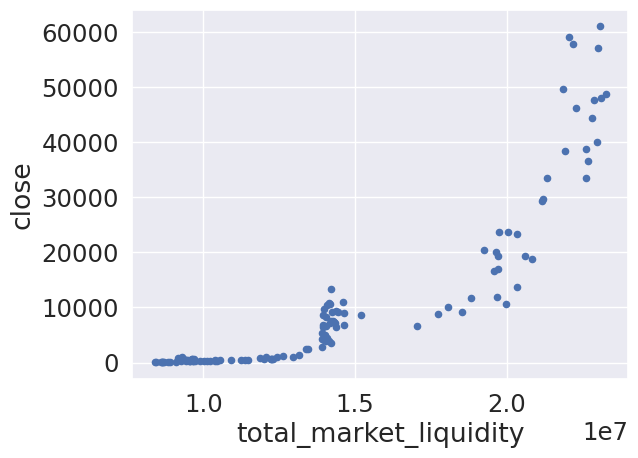

In [77]:
# Visualize the data

df_2013.plot(kind='scatter', x='total_market_liquidity', y='close')
plt.show()

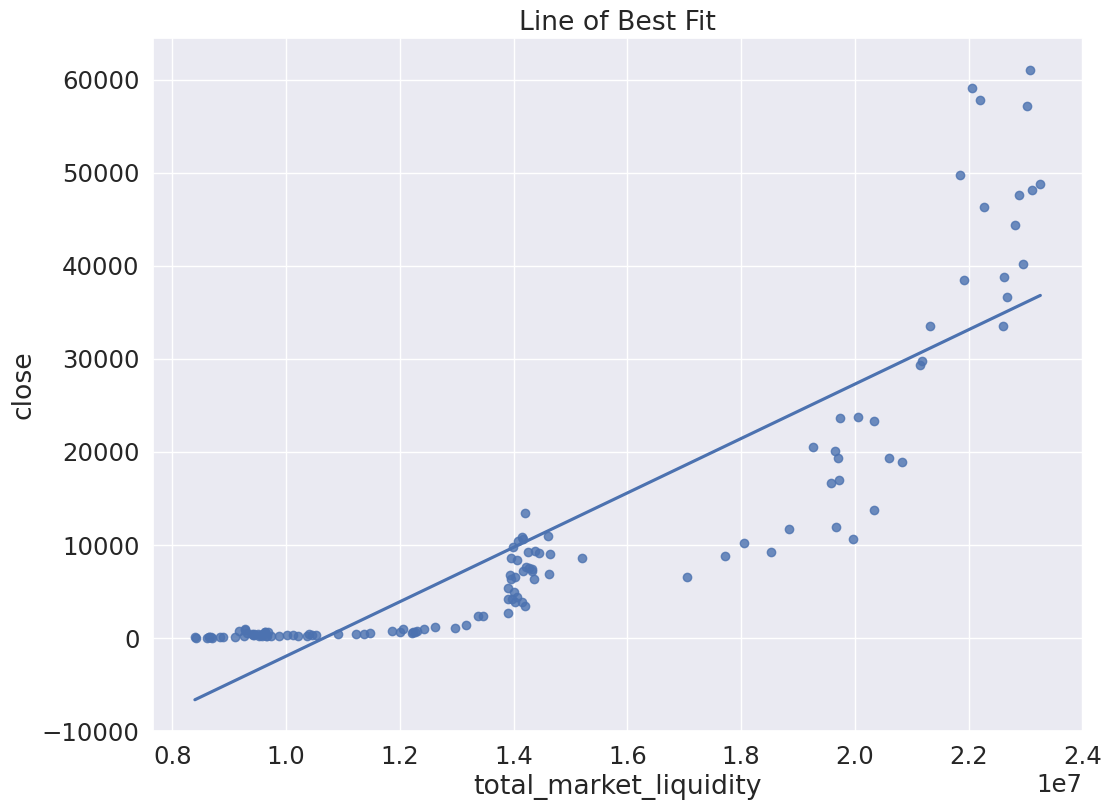

In [78]:
# plot line of best fit

sns.set(font_scale=1.6)

fig, ax1 = plt.subplots(figsize=(12, 9))

ax1 = sns.regplot(x='total_market_liquidity', y='close', data=df_2013, ci=None)
ax1.set_title("Line of Best Fit");

In [79]:
#instantiate the model

model_lr_13 = sklearn.linear_model.LinearRegression()

In [80]:
#define variables and fit the model

X = np.c_[df_2013['total_market_liquidity']]

y = np.c_[df_2013['close']]

# Train the model
model_lr_13.fit(X, y)

LinearRegression()

In [81]:
# print coefficients

print("Slope Coefficient of Fed Assets: {}".format(model_lr_13.coef_, 2))
print("Intercept Coefficient of Fed Assets: {}".format(model_lr_13.intercept_))

Slope Coefficient of Fed Assets: [[0.00292221]]
Intercept Coefficient of Fed Assets: [-31160.10443732]


In [82]:
# Pass data and `formula` into ols(), use and `.fit()` the model to the data
from statsmodels.formula.api import ols

model_fit = ols(formula="close ~ total_market_liquidity", data=df_2013).fit()

In [83]:
# extract key model parameters

x1 = model_fit.params['total_market_liquidity']

print( "uplift factor for total_market_liquidity = {p}".format(p=x1) )
print( model_fit.summary() )

uplift factor for total_market_liquidity = 0.002922212015870424
                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     410.3
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           1.10e-40
Time:                        11:06:52   Log-Likelihood:                -1270.3
No. Observations:                 123   AIC:                             2545.
Df Residuals:                     121   BIC:                             2550.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [84]:
# check the quality of the model

y_pred = model_lr_13.predict(X)

In [85]:
#comparisson between predicted prices and actual prices

comparison = pd.DataFrame(np.append(y, y_pred, axis=1), columns=["Actuals", "Prediction"], index=df_2013.index)
comparison.tail()

,Actuals,Prediction
date,,
2022-11-01,20481.88,25136.63
2022-12-01,16962.99,26458.73
2023-01-01,16620.82,26070.08
2023-02-01,23711.53,27432.62
2023-03-01,23652.75,26525.48


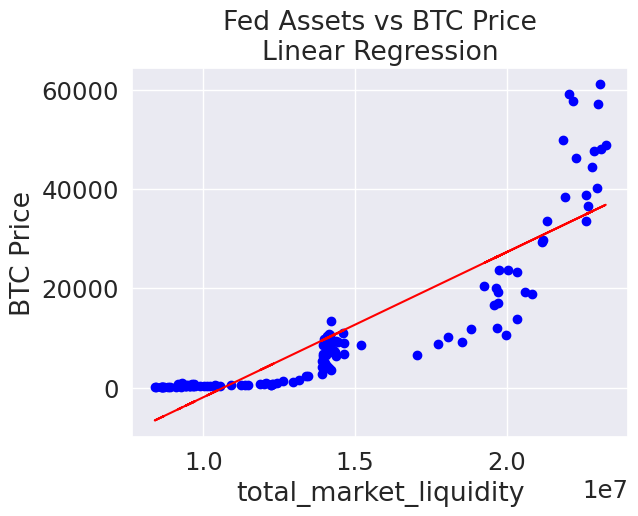

In [86]:
# Visualising the Polynomial Regression results
plt.scatter(X, y, color = 'blue')
 
plt.plot(X, model_lr_13.predict(X), color = 'red')
plt.title('Fed Assets vs BTC Price\nLinear Regression')
plt.xlabel('total_market_liquidity')
plt.ylabel('BTC Price')
 
plt.show()

In [87]:
# Score directly with the model, default: R2
r2 = model_lr_13.score(X, y)

print(r2)

0.7722442231234676


Performance decreases when going back to 2013

In [88]:
def estimated_btc_price(fed_assets, coeff, inter):
    fed_assets = round(fed_assets, 2)
    est_y = (fed_assets * coeff) + inter
    prediction = est_y
    
    return prediction

In [89]:
# run forecast based on Fed Assets 

intercept = model_lr_13.intercept_
coefficient = model_lr_13.coef_
fed_assets = 10000000

estimated_btc_price(fed_assets, coefficient, intercept)

array([[-1937.98427861]])

#Fit polynomial regression

In [90]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
 
poly = PolynomialFeatures(degree = 5)
X_poly = poly.fit_transform(X)
 
poly.fit(X_poly, y)
lin2 = sklearn.linear_model.LinearRegression()
lin2.fit(X_poly, y)

LinearRegression()

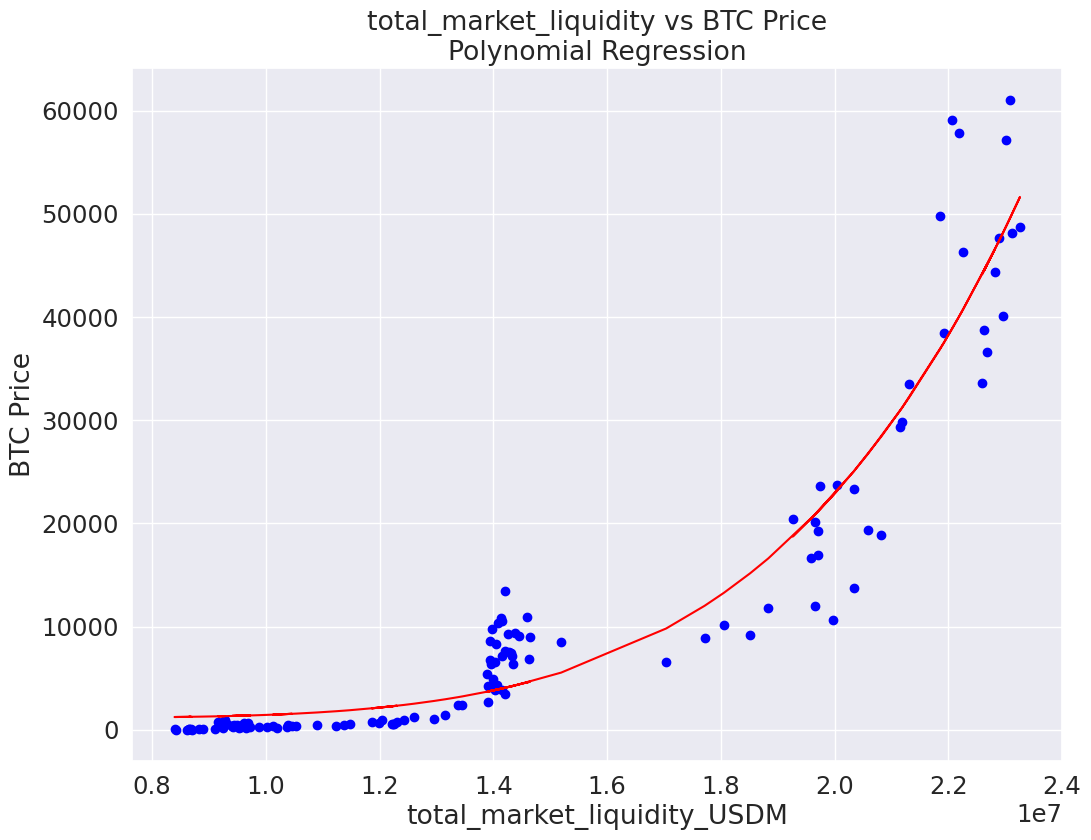

In [91]:
# Visualising the Polynomial Regression results

fig, ax1 = plt.subplots(figsize=(12, 9))

ax1.scatter(X, y, color = 'blue')
ax1.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red')
ax1.set_title('total_market_liquidity vs BTC Price\nPolynomial Regression')
ax1.set_xlabel('total_market_liquidity_USDM')
ax1.set_ylabel('BTC Price')

#plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.show()

In [92]:
# Score directly with the model, default: R2
r2 = lin2.score(X_poly, y)

print(r2)

0.909319389484587


In [93]:
# predict series of Fed assets values

y_pred_poly = lin2.predict(poly.fit_transform(X))


In [94]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_pred_poly, y)

print(mse)

21765016.055089034


In [95]:
# print coefficients

print("Slope Coefficient of Fed Assets: {}".format(lin2.coef_, 2))
print("Intercept Coefficient of Fed Assets: {}".format(lin2.intercept_))

Slope Coefficient of Fed Assets: [[ 0.00000000e+00  1.58965905e-33 -5.62492414e-40 -8.26277505e-33
  -9.01397665e-26  1.12771899e-32]]
Intercept Coefficient of Fed Assets: [1224.36129358]


In [96]:
# Predicting a new result with Polynomial Regression after converting predict variable to 2D array
pred2 = 25000000
pred2array = np.array([[pred2]])
lin2.predict(poly.fit_transform(pred2array))

array([[76142.32239486]])

In [97]:
# predict series of Fed assets values

liquidity_series = [3000000, 4000000, 5000000, 6000000, 6500000, 7000000, 7500000, 8000000, 8500000, 9000000, 9500000, 10000000, 10250000, 10500000, 11000000, 12000000, 12250000,
                    13000000, 14000000, 15000000, 16000000, 17000000, 18000000, 19000000, 20000000, 21000000, 22000000, 23000000, 24000000, 25000000, 26000000, 27000000, 28000000
                    , 29000000, 30000000]

btc_close_pred = []

for i in liquidity_series:
  pred = lin2.predict(poly.fit_transform(np.array([[i]])))
  btc_close_pred.append(pred.item(0,0))



In [98]:
#building a datafram with predictions


pred = {'price_pred': btc_close_pred, 'total_market_liquidity_projection': liquidity_series}

predictions_poly = pd.DataFrame(data=pred)

predictions_poly.head()

,price_pred,total_market_liquidity_projection
0,1219.80,3000000
1,1212.83,4000000
2,1203.27,5000000
3,1195.23,6000000
4,1194.30,6500000


In [99]:
predictions_poly.tail()

,price_pred,total_market_liquidity_projection
30,94021.18,26000000
31,115135.74,27000000
32,139904.00,28000000
33,168778.34,29000000
34,202246.86,30000000


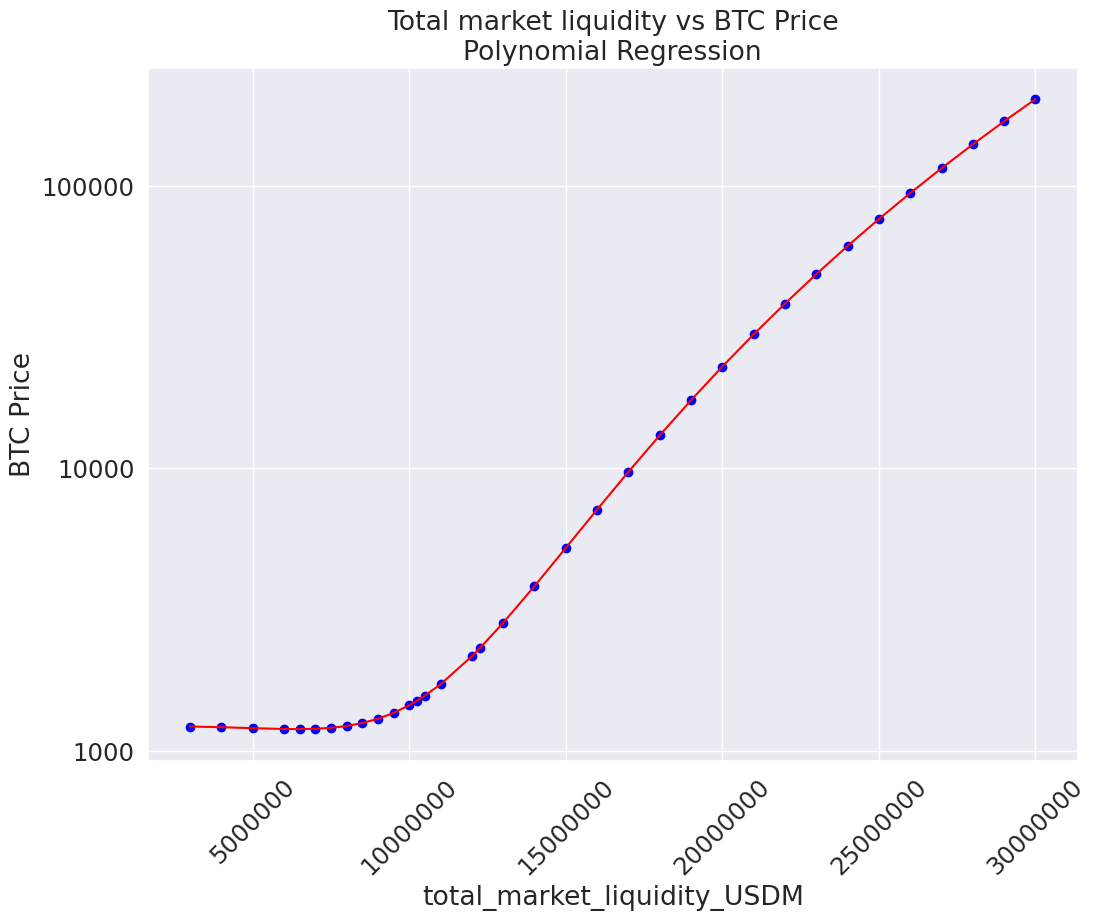

In [100]:
# Visualising the Polynomial Regression predictions

import matplotlib

fig, ax1 = plt.subplots(figsize=(12, 9))

X_proj = np.c_[predictions_poly['total_market_liquidity_projection']]

ax1.scatter(predictions_poly['total_market_liquidity_projection'], predictions_poly['price_pred'], color = 'blue')
ax1.plot(predictions_poly['total_market_liquidity_projection'], lin2.predict(poly.fit_transform(X_proj)), color = 'red')
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
ax1.set_title('Total market liquidity vs BTC Price\nPolynomial Regression')
ax1.set_xlabel('total_market_liquidity_USDM')
ax1.set_ylabel('BTC Price')
 
plt.xticks(rotation=45) 
plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.show()

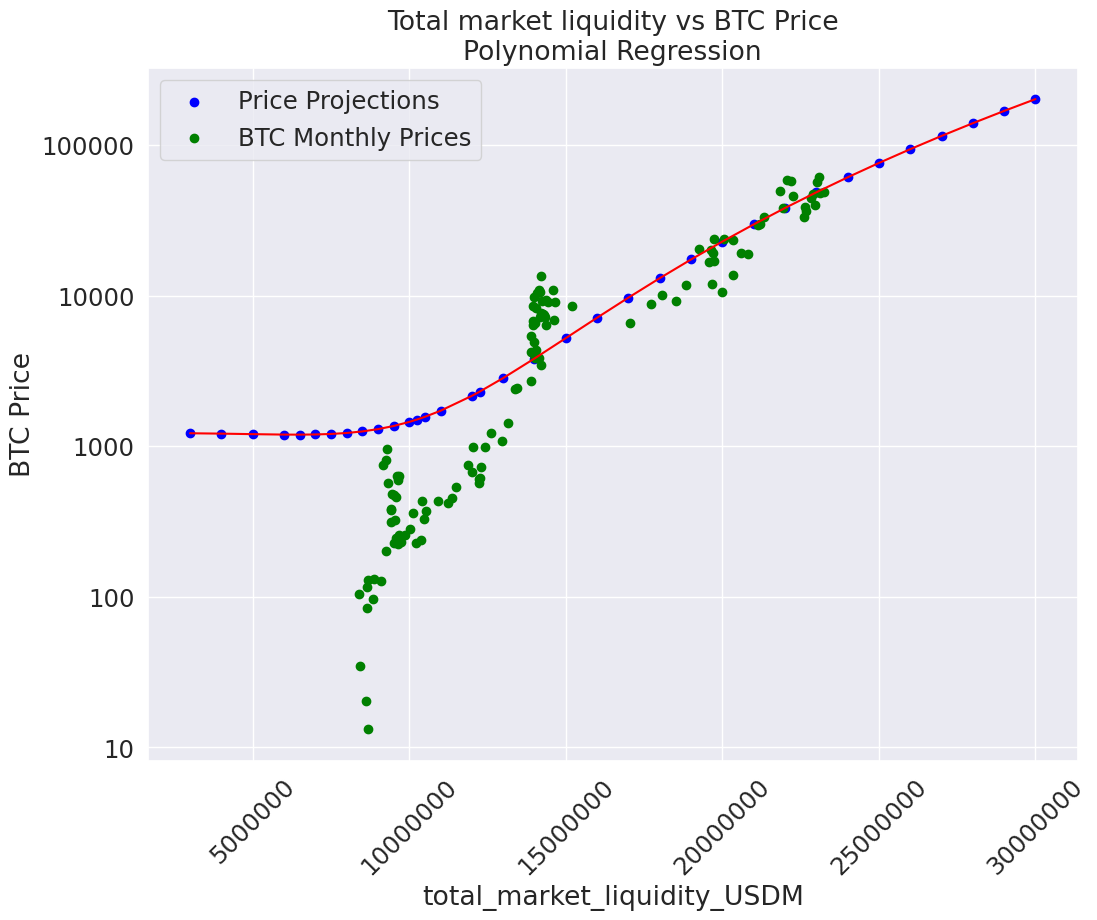

In [101]:
# Visualising the Polynomial Regression predictions

import matplotlib

fig, ax1 = plt.subplots(figsize=(12, 9))

X_proj = np.c_[predictions_poly['total_market_liquidity_projection']]

ax1.scatter(predictions_poly['total_market_liquidity_projection'], predictions_poly['price_pred'], color = 'blue', label = 'Price Projections')
ax1.plot(predictions_poly['total_market_liquidity_projection'], lin2.predict(poly.fit_transform(X_proj)), color = 'red')
ax1.scatter(X, y ,color = 'green', label = 'BTC Monthly Prices')
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
ax1.set_title('Total market liquidity vs BTC Price\nPolynomial Regression')
ax1.set_xlabel('total_market_liquidity_USDM')
ax1.set_ylabel('BTC Price')
 
plt.xticks(rotation=45) 
plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.legend(loc='upper left')
plt.show()

#Plot charts with confidence intervals

In [102]:
#estimate confidence intervals

stdev = np.sqrt(sum((lin2.predict(poly.fit_transform(X)) - y)**2) / (len(y) - 2))

print(stdev)

[4703.69731026]


In [103]:
#calculate bands with 95% confidence interval (z-value 1.96)

z_score = 1.96

conf_upper = []

conf_lower = []

for i in predictions_poly['price_pred']:
  pred_up = i + z_score*stdev
  conf_upper.append(pred_up.item(0))
  pred_down = i - z_score*stdev
  conf_lower.append(pred_down.item(0))

  #btc_close_pred.append(pred.item(0,0))

In [104]:
#add bands to predictions poly df

predictions_poly['95_conf_upper'] = conf_upper
predictions_poly['95_conf_lower'] = conf_lower

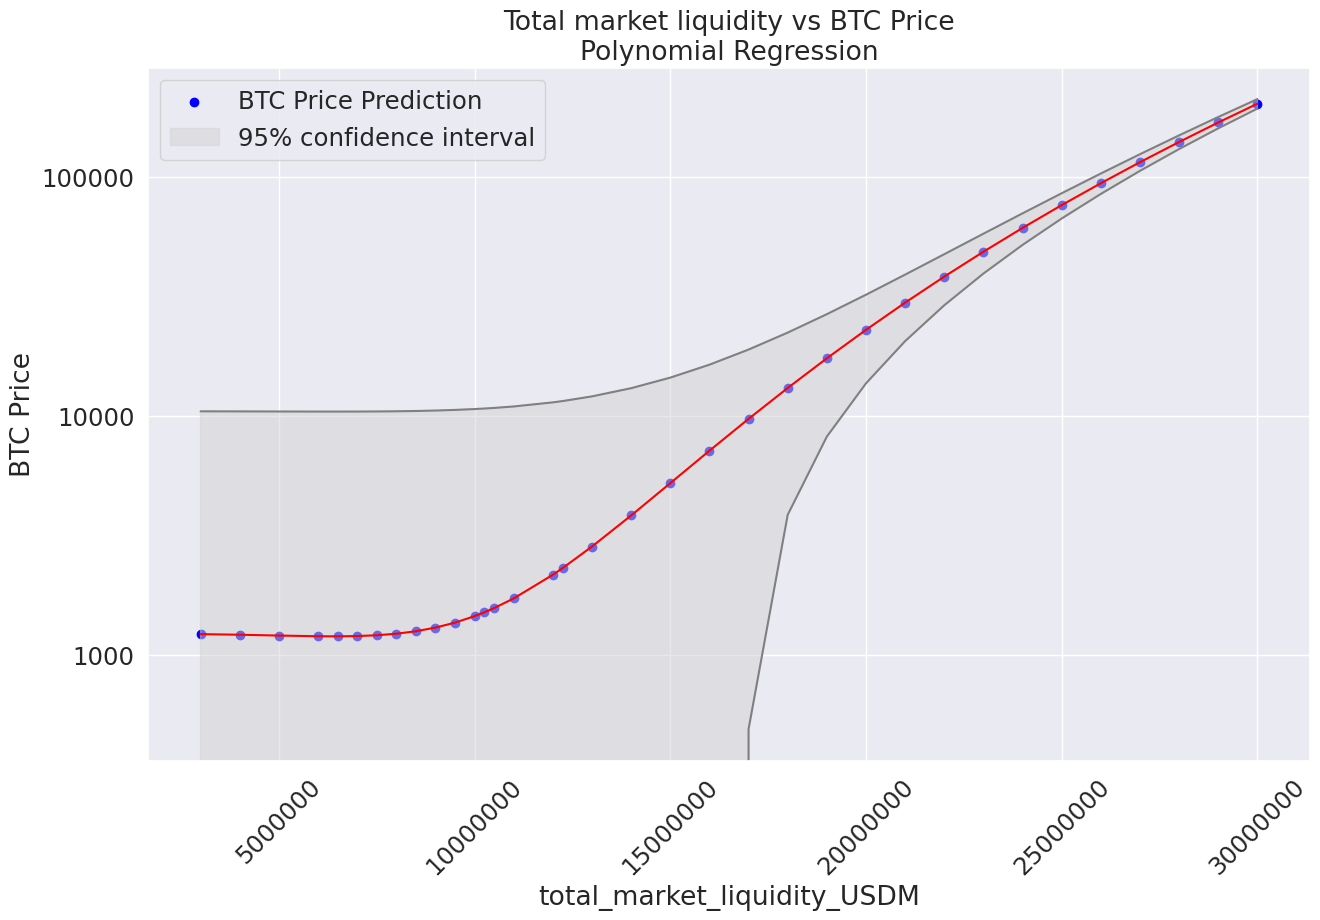

In [105]:
# Visualising the Polynomial Regression predictions

import matplotlib

fig, ax1 = plt.subplots(figsize=(15, 9))

X_proj = np.c_[predictions_poly['total_market_liquidity_projection']]

ax1.scatter(predictions_poly['total_market_liquidity_projection'], predictions_poly['price_pred'], color = 'blue', label='BTC Price Prediction')
ax1.plot(predictions_poly['total_market_liquidity_projection'], lin2.predict(poly.fit_transform(X_proj)), color = 'red')
ax1.plot(predictions_poly['total_market_liquidity_projection'], predictions_poly['95_conf_upper'], color = 'grey')
ax1.plot(predictions_poly['total_market_liquidity_projection'], predictions_poly['95_conf_lower'], color = 'grey')
ax1.fill_between(predictions_poly['total_market_liquidity_projection'],predictions_poly['95_conf_upper'], predictions_poly['95_conf_lower'], color='lightgrey', alpha=.5, label = '95% confidence interval') #fill in area between the two lines
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
ax1.set_title('Total market liquidity vs BTC Price\nPolynomial Regression')
ax1.set_xlabel('total_market_liquidity_USDM')
ax1.set_ylabel('BTC Price')
 
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.show()

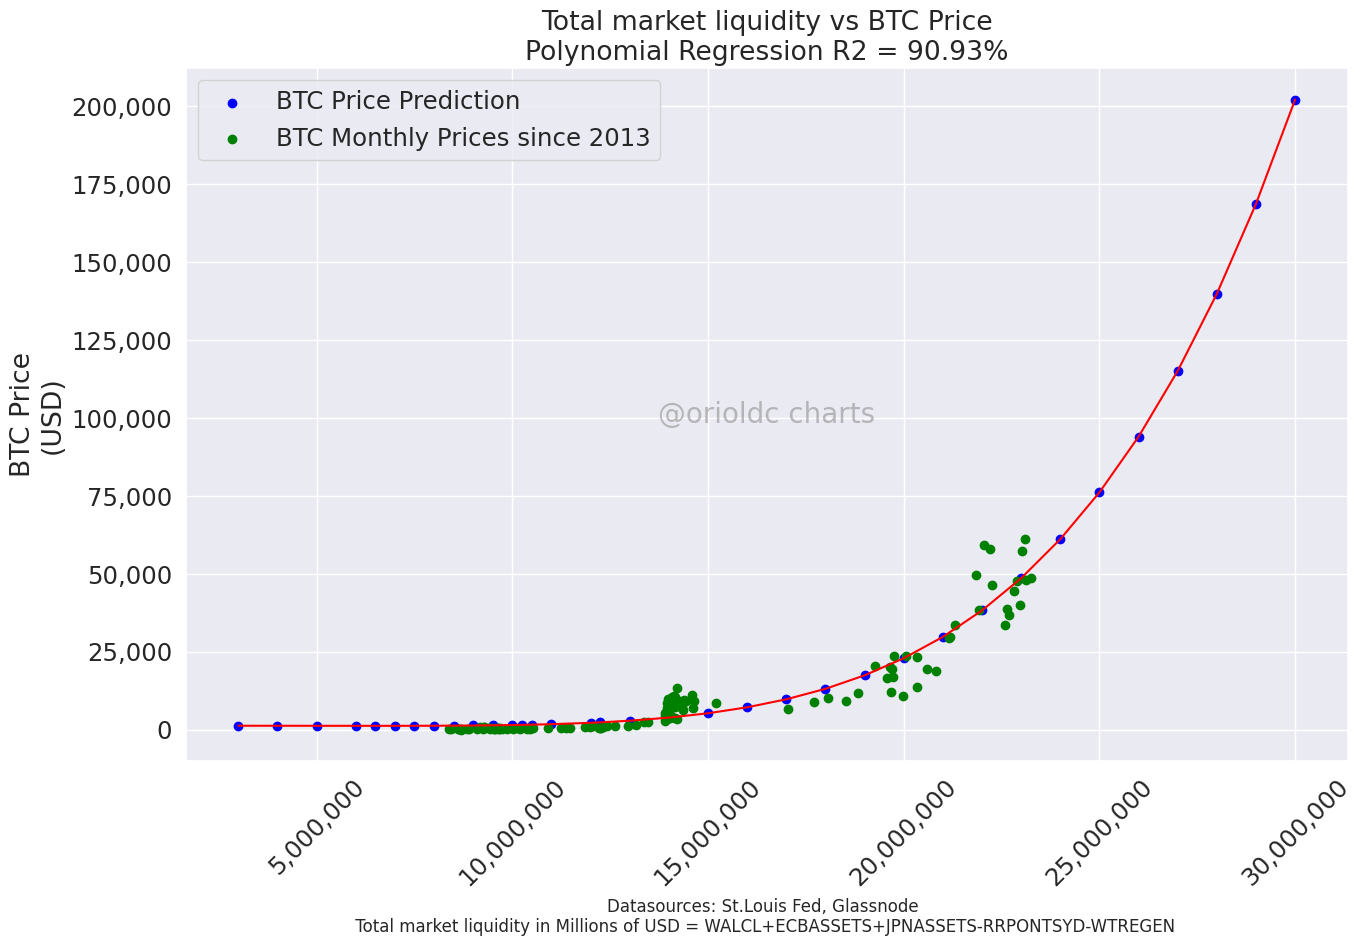

In [106]:
# Visualising the Polynomial Regression predictions

import matplotlib

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_TotalLiquidity_{}.jpg'.format(yesterday)

fig, ax1 = plt.subplots(figsize=(15, 9))

X_proj = np.c_[predictions_poly['total_market_liquidity_projection']]

r2_rounded = round(r2,4)*100

ax1.scatter(predictions_poly['total_market_liquidity_projection'], predictions_poly['price_pred'], color = 'blue', label='BTC Price Prediction')
ax1.plot(predictions_poly['total_market_liquidity_projection'], lin2.predict(poly.fit_transform(X_proj)), color = 'red')
#ax1.plot(predictions_poly['total_market_liquidity_projection'], predictions_poly['95_conf_upper'], color = 'grey')
#ax1.plot(predictions_poly['total_market_liquidity_projection'], predictions_poly['95_conf_lower'], color = 'grey')
#ax1.fill_between(predictions_poly['total_market_liquidity_projection'],predictions_poly['95_conf_upper'], predictions_poly['95_conf_lower'], color='lightgrey', alpha=.5, label = '95% confidence interval') #fill in area between the two lines
ax1.scatter(X, y ,color = 'green', label = 'BTC Monthly Prices since 2013')
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax1.set_yscale('log')
#ax1.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
ax1.set_title(f'Total market liquidity vs BTC Price\nPolynomial Regression R2 = {r2_rounded}%')
#ax1.set_xlabel('total_market_liquidity_USDM')
ax1.set_ylabel('BTC Price\n(USD)')
ax1.text(0.5, 0.5, '@orioldc charts', transform=ax1.transAxes,
        fontsize=20, color='gray', alpha=0.5,
        ha='center', va='center')
 
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.figtext(0.51, -0.08, "Datasources: St.Louis Fed, Glassnode\n Total market liquidity in Millions of USD = WALCL+ECBASSETS+JPNASSETS-RRPONTSYD-WTREGEN", ha="center", fontsize=12)
plt.savefig(filename, facecolor='white', dpi=96)
plt.show()

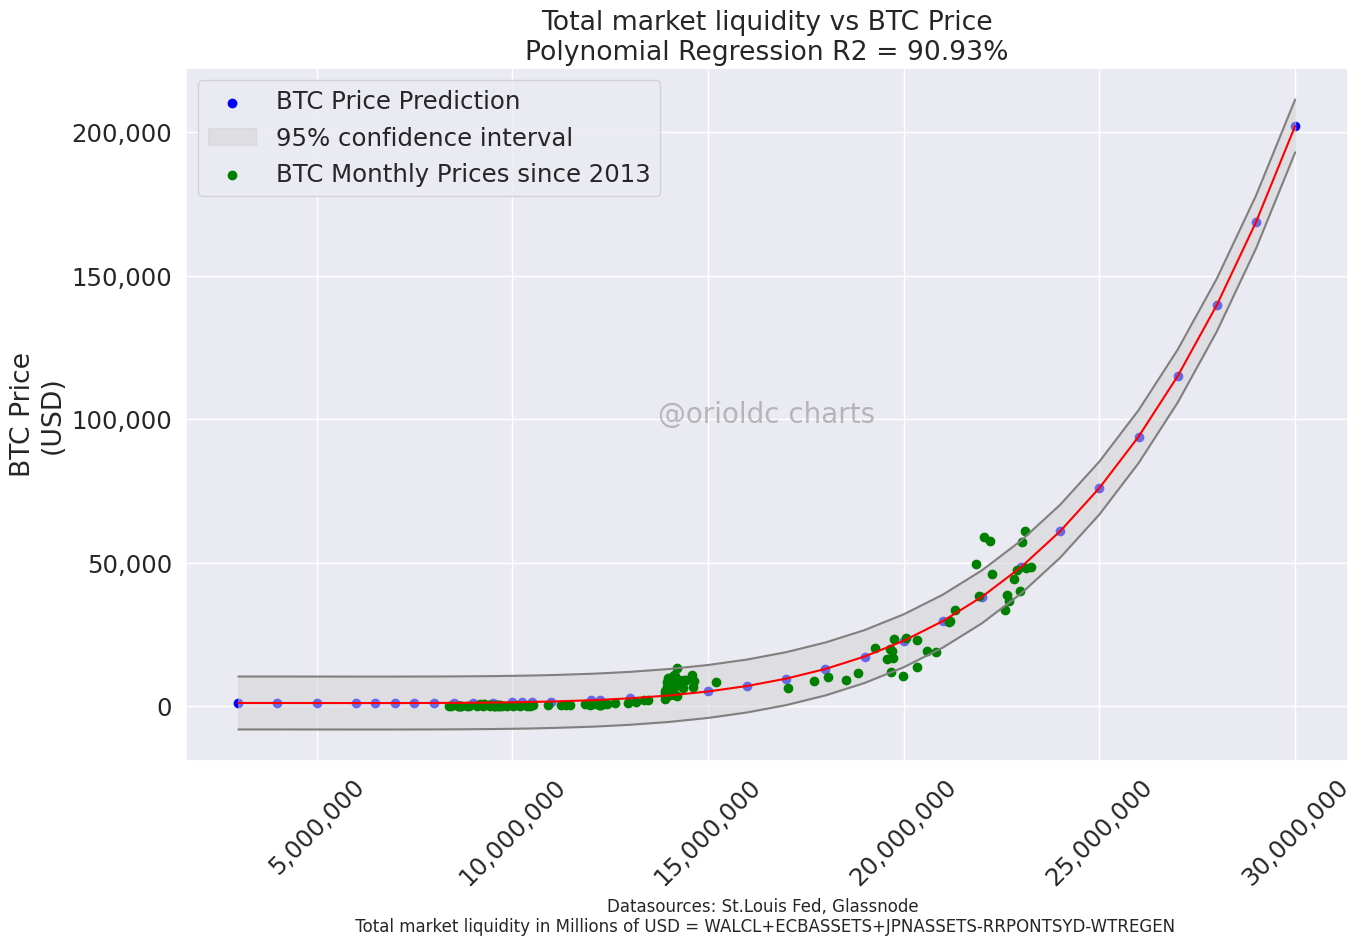

In [107]:
# Visualising the Polynomial Regression predictions

import matplotlib

yesterday = dt.date.today() - dt.timedelta(days=1)

filename = 'BtcUsd_TotalLiquidity_confidence_int_{}.jpg'.format(yesterday)

fig, ax1 = plt.subplots(figsize=(15, 9))

X_proj = np.c_[predictions_poly['total_market_liquidity_projection']]

r2_rounded = round(r2,4)*100

ax1.scatter(predictions_poly['total_market_liquidity_projection'], predictions_poly['price_pred'], color = 'blue', label='BTC Price Prediction')
ax1.plot(predictions_poly['total_market_liquidity_projection'], lin2.predict(poly.fit_transform(X_proj)), color = 'red')
ax1.plot(predictions_poly['total_market_liquidity_projection'], predictions_poly['95_conf_upper'], color = 'grey')
ax1.plot(predictions_poly['total_market_liquidity_projection'], predictions_poly['95_conf_lower'], color = 'grey')
ax1.fill_between(predictions_poly['total_market_liquidity_projection'],predictions_poly['95_conf_upper'], predictions_poly['95_conf_lower'], color='lightgrey', alpha=.5, label = '95% confidence interval') #fill in area between the two lines
ax1.scatter(X, y ,color = 'green', label = 'BTC Monthly Prices since 2013')
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax1.set_yscale('log')
#ax1.yaxis.set_major_formatter(ScalarFormatter()) # removes scientific notation from y-axis
ax1.set_title(f'Total market liquidity vs BTC Price\nPolynomial Regression R2 = {r2_rounded}%')
#ax1.set_xlabel('total_market_liquidity_USDM')
ax1.set_ylabel('BTC Price\n(USD)')
ax1.text(0.5, 0.5, '@orioldc charts', transform=ax1.transAxes,
        fontsize=20, color='gray', alpha=0.5,
        ha='center', va='center')
 
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.figtext(0.51, -0.08, "Datasources: St.Louis Fed, Glassnode\n Total market liquidity in Millions of USD = WALCL+ECBASSETS+JPNASSETS-RRPONTSYD-WTREGEN", ha="center", fontsize=12)
plt.savefig(filename, facecolor='white', dpi=96)
plt.show()

In [108]:
df.tail(2)

,date,open,high,low,close,month_year,fed_assets_USDM,japan_assets,euro_assets,repo_value,fed_capital_liabilities,jpy_usd,eur_usd,japan_assets_USDM,euro_assets_USDM,repo_value_USDM,fed_capital_liabilities_USDM,total_central_bank_assets_USDM,total_market_liquidity
150,2023-02-01,23139.36,23764.03,22968.08,23711.53,2023-02,8408984.00,7395800.00,7865135.00,2079.45,505.27,0.01,1.09,5684267.12,8542281.73,2079451.63,505269.50,22635532.85,20050811.72
151,2023-03-01,23150.93,23871.92,23095.04,23652.75,2023-03,8552199.20,7348498.00,7811511.20,2185.68,278.12,0.01,1.06,5389516.39,8262476.87,2185684.00,278125.00,22204192.46,19740383.46


In [109]:
df['total_market_liquidity'].max()

23261412.429664407

In [110]:
max_index = df['total_market_liquidity'].idxmax()
max_date = df.loc[max_index, 'date']
print(max_date)

2021-09-01 00:00:00


In [111]:
predictions_poly.tail(12)

,price_pred,total_market_liquidity_projection,95_conf_upper,95_conf_lower
23,17400.70,19000000,26619.94,8181.45
24,22889.01,20000000,32108.25,13669.76
25,29751.07,21000000,38970.32,20531.83
26,38227.07,22000000,47446.31,29007.82
27,48583.42,23000000,57802.67,39364.17
28,61114.17,24000000,70333.42,51894.93
29,76142.32,25000000,85361.57,66923.08
30,94021.18,26000000,103240.43,84801.94
31,115135.74,27000000,124354.99,105916.50
32,139904.00,28000000,149123.25,130684.75


In [114]:
def predict_btc_based_on_liquidity(liquidity):
  #####
  # returns the predicted lower bound for price
  # the predicted price
  # the predicted upper bound for price
  # upper bounds are calculated using 1.96 z-score (prodividing 95% condidence interval)
  #####
  pred = lin2.predict(poly.fit_transform(np.array([[liquidity]])))
  pred_up = pred+z_score*stdev
  pred_down = pred-z_score*stdev
  return pred_down.item(0), pred.item(0,0), pred_up.item(0)

In [115]:
predict_btc_based_on_liquidity(20200000)

(14924.95384115696, 24144.20056927301, 33363.44729738906)